---
title: Gene set enrichment of metabolic pathways for RPs vs Neurons at E13.5, E15.5 and E17.5 embryonic ages as well as for S0 and S2 state cells at E15.5.
authors:
- saksham.malhotra@elucidata.io
tags:
- SingleCell
- GSEA
- RPsvsNeurons
created_at: 2019-03-15
updated_at: 2019-03-15
tldr: Enrichment of metabolic pathways for multple days, using GSEA and differential expression results of RPs vs Neurons. Also finds enrichment of metabolic pathways for S0 and S2 state cells at E15.5
---

In [1]:
library(GSA)
library(Seurat)
library(ggsci)
library(fgsea)
packageVersion("Seurat")

#set plot widths for the notebook
library(repr)
options(repr.plot.width=15, repr.plot.height=9)

Loading required package: ggplot2

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix

Loading required package: Rcpp



[1] ‘2.3.0’

## Get metabolic pathway gene lists

Pathways used:- 
1. Fatty acid metabolism
2. Glycine, Serine metabolism
3. Glycolysis
4. Methionine metabolism
5. One carbon metabolism
6. Valine, Leucine degradation

In [7]:
system("wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/6.2/c2.cp.kegg.v6.2.symbols.gmt", intern = TRUE)
system("ls", intern = TRUE)
KEGG_gmt <- GSA.read.gmt('c2.cp.kegg.v6.2.symbols.gmt')
KEGG_gmt$genesets <- lapply(KEGG_gmt$genesets, function(x) stringr::str_to_title(unlist(x)))

character(0)

[1] "abcd.RData"                                            
 [2] "c2.cp.kegg.v6.2.symbols.gmt"                           
 [3] "c2.cp.kegg.v6.2.symbols.gmt.1"                         
 [4] "c2.cp.kegg.v6.2.symbols.gmt.2"                         
 [5] "cluster_barplots"                                      
 [6] "cohort_df.csv"                                         
 [7] "def.RData"                                             
 [8] "E135_Cortical_metabolic_minclusters.rds"               
 [9] "E135_Cortical.rds"                                     
[10] "E135_RPs_vs_Neurons_intomix.png"                       
[11] "E13_RPs_random_hist.pdf"                               
[12] "E155_Cortical_metabolic_minclusters.rds"               
[13] "E155_Cortical.rds"                                     
[14] "E15_RPs_random_hist.pdf"                               
[15] "E175_Cortical_metabolic_minclusters.rds"               
[16] "E175_Cortical.rds"                                     
[17] "E17_RPs_random_hist.pdf"                               
[18] "Freda_random_genes_TSNE_limit_cluster_iterations.Rdata"
[19] "gct_to_df.gct"                                         
[20] "GSEA_RPsvsNeurons_all_days.ipynb"                      
[21] "input_df.csv"                                          
[22] "KnowledgeRepo_E135.RData"                              
[23] "KnowledgeRepo_E155.RData"                              
[24] "KnowledgeRepo_E175.RData"                              
[25] "metabolic_genes_TSNE.Rdata"                            
[26] "meta_sample_df.csv"                                    
[27] "raw_intensity_df.csv"                                  
[28] "RPsvsNeurons_GSEA_3_days.csv"                          
[29] "RPsvsNeurons_GSEA_CombiTgenes_3days.csv"               
[30] "scripts"                                               
[31] "SDMTools_1.1-221.2.tar.gz"                             
[32] "standard_df.csv"

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
16

#### Define identifiers for pathways in KEGG

In [17]:
pathways_KEGG_IDs <- c("KEGG_FATTY_ACID_METABOLISM", "KEGG_GLYCOLYSIS_GLUCONEOGENESIS", 
                       "KEGG_CYSTEINE_AND_METHIONINE_METABOLISM","KEGG_ONE_CARBON_POOL_BY_FOLATE",
                       "KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM",
                       "KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION")

In [4]:
metabolic_pathways <- lapply(pathways_KEGG_IDs, function(x) 
    unlist(KEGG_gmt$genesets[which(KEGG_gmt$geneset.names == x)]))
names(metabolic_pathways) <- pathways_KEGG_IDs
str(metabolic_pathways)

List of 6
 $ KEGG_FATTY_ACID_METABOLISM                    : chr [1:42] "Cpt1a" "Cpt1c" "Acads" "Aldh1b1" ...
 $ KEGG_GLYCOLYSIS_GLUCONEOGENESIS               : chr [1:62] "Acss2" "Gck" "Pgk2" "Pgk1" ...
 $ KEGG_CYSTEINE_AND_METHIONINE_METABOLISM       : chr [1:34] "Amd1" "Srm" "Adi1" "Ahcy" ...
 $ KEGG_ONE_CARBON_POOL_BY_FOLATE                : chr [1:17] "Mthfd2" "Gart" "Tyms" "Ftcd" ...
 $ KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM  : chr [1:31] "Alas1" "Alas2" "Glyctk" "Maob" ...
 $ KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION: chr [1:44] "Aox1" "Aldh1b1" "Acads" "Acadsb" ...


In [5]:
metabolic_pathways <- lapply(metabolic_pathways, stringr::str_to_title)
str(metabolic_pathways)

List of 6
 $ KEGG_FATTY_ACID_METABOLISM                    : chr [1:42] "Cpt1a" "Cpt1c" "Acads" "Aldh1b1" ...
 $ KEGG_GLYCOLYSIS_GLUCONEOGENESIS               : chr [1:62] "Acss2" "Gck" "Pgk2" "Pgk1" ...
 $ KEGG_CYSTEINE_AND_METHIONINE_METABOLISM       : chr [1:34] "Amd1" "Srm" "Adi1" "Ahcy" ...
 $ KEGG_ONE_CARBON_POOL_BY_FOLATE                : chr [1:17] "Mthfd2" "Gart" "Tyms" "Ftcd" ...
 $ KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM  : chr [1:31] "Alas1" "Alas2" "Glyctk" "Maob" ...
 $ KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION: chr [1:44] "Aox1" "Aldh1b1" "Acads" "Acadsb" ...


### Function to run GSEA on a ranked named vector of log fold changes, and a list of pathways

In [6]:
run_GSEA <- function(ranked_genes_vector, metabolic_pathways){
    require(fgsea)
    fgseaRes <- fgsea(pathways = metabolic_pathways, 
                  stats = ranked_genes_vector,
                  minSize=5,
                  maxSize=500,
                  nperm=100000)
    fgseaRes
}

## 13th day

### Read the 13th day Seurat object from previous analysis

In [7]:
E135_Cortical <- readRDS("E135_Cortical.rds")

In [8]:
table(E135_Cortical@ident)


    IPs Neurons     RPs 
    245     656     139 

### Get differentially expressed genes between RPs and Neurons

In [9]:
table(E135_Cortical@ident)


    IPs Neurons     RPs 
    245     656     139 

In [10]:
E135_clusterRPsvsNeurons.markers <- FindMarkers(object = E135_Cortical, ident.1 = "RPs", ident.2 = "Neurons", 
                                           logfc.threshold = 0.005, min.pct = 0.05)
dim(E135_clusterRPsvsNeurons.markers)

[1] 7248    5

In [13]:
head(E135_clusterRPsvsNeurons.markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dbi,2.569346e-87,2.460031,0.935,0.201,3.415945e-83
Ddah1,1.223897e-80,1.932455,0.676,0.047,1.627172e-76
Sox2,7.221524e-78,1.898914,0.590,0.024,9.601017e-74
Gas1,1.972155e-77,1.838423,0.547,0.014,2.621980e-73
Nr2e1,2.128761e-77,1.727004,0.583,0.021,2.830187e-73
Ttyh1,1.273460e-75,1.834276,0.727,0.082,1.693066e-71


### Running GSEA on 13th day RPs vs Neurons

#### Sorting genes based on fold changes

In [14]:
clusterRPsvsNeurons.markers_sorted_E13 <- E135_clusterRPsvsNeurons.markers[order(E135_clusterRPsvsNeurons.markers$avg_logFC),]
ranked_genes_RPsvsNeurons_E13 <- clusterRPsvsNeurons.markers_sorted_E13$avg_logFC
names(ranked_genes_RPsvsNeurons_E13) <- rownames(clusterRPsvsNeurons.markers_sorted_E13)
head(ranked_genes_RPsvsNeurons_E13)

Neurod6     Stmn2     Tubb3   Neurod2      Nsg2     Crmp1 
-2.671551 -2.590849 -2.086894 -2.038163 -1.986641 -1.979339

In [15]:
fgsea_Res_E13 <- run_GSEA(ranked_genes_RPsvsNeurons_E13, metabolic_pathways) 
fgsea_Res_E13

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_FATTY_ACID_METABOLISM,3.060808e-02,0.0306080778,0.5262156,1.565186,1498,22,"Eci1 , Acadl , Hadh , Echs1 , Acat2 , Acadm , Aldh2 , Acaa2 , Hadha , Hadhb , Acsl3 , Aldh7a1, Eci2 , Adh5 , Aldh9a1, Acox1"
KEGG_GLYCOLYSIS_GLUCONEOGENESIS,6.144645e-05,0.0003686787,0.7065214,2.170557,2,25,"Aldoc, Ldha , Eno1 , Aldoa, Tpi1 , Acss1, Dlat , Pgk1 , Hk2 , Aldh2, Pfkl"
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM,2.841313e-02,0.0306080778,0.5627921,1.590992,1399,18,"Ldha , Dnmt3a, Srm , Mtap , Mat2a"
KEGG_ONE_CARBON_POOL_BY_FOLATE,1.598469e-02,0.0239770394,0.7143842,1.668749,801,9,"Dhfr , Tyms , Mthfd1 , Shmt2 , Aldh1l1, Atic , Shmt1"
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,7.234967e-03,0.0144699340,0.7494173,1.750584,362,9,"Psat1, Phgdh, Psph , Shmt2"
KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,2.526141e-03,0.0075784243,0.5639945,1.808723,121,30,"Hmgcs1 , Hsd17b10, Hadh , Echs1 , Acat2 , Acadm , Aldh2 , Bckdhb , Acaa2 , Pcca , Oxct1 , Hadha , Acad8 , Hadhb , Ivd , Dbt , Aldh7a1 , Aldh9a1 , Hibadh"


## 15th day

### Read the 15th day Seurat object from previous analysis

In [16]:
E155_Cortical <- readRDS("E155_Cortical.rds")

### Get differentially expressed genes between RPs and Neurons

In [17]:
E155_clusterRPsvsNeurons.markers <- FindMarkers(object = E155_Cortical, ident.1 = "RPs", ident.2 = "Neurons", 
                                           logfc.threshold = 0.005, min.pct = 0.05)
dim(E155_clusterRPsvsNeurons.markers)

[1] 7967    5

In [18]:
head(E155_clusterRPsvsNeurons.markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Aldoc,2.862642e-201,2.111922,0.706,0.040,4.347781e-197
Nr2e1,7.640299e-177,1.728386,0.604,0.030,1.160409e-172
Zfp36l1,1.258227e-169,1.384238,0.533,0.019,1.910995e-165
Sox2,4.779684e-169,1.623915,0.690,0.052,7.259384e-165
Mfge8,8.732074e-165,1.647995,0.538,0.022,1.326227e-160
Dbi,3.940412e-163,2.624688,0.980,0.226,5.984698e-159


### Running GSEA on 15th day RPs vs Neurons

In [19]:
clusterRPsvsNeurons.markers_sorted_E15 <- E155_clusterRPsvsNeurons.markers[order(E155_clusterRPsvsNeurons.markers$avg_logFC),]
ranked_genes_RPsvsNeurons_E15 <- clusterRPsvsNeurons.markers_sorted_E15$avg_logFC
names(ranked_genes_RPsvsNeurons_E15) <- rownames(clusterRPsvsNeurons.markers_sorted_E15)
head(ranked_genes_RPsvsNeurons_E15)

Neurod6     Stmn2     Tubb3   Neurod2      Mapt     Crmp1 
-2.431345 -2.364554 -2.252895 -2.001969 -1.891729 -1.787787

In [20]:
fgsea_Res_E15 <- run_GSEA(ranked_genes_RPsvsNeurons_E15, metabolic_pathways) 
fgsea_Res_E15

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_FATTY_ACID_METABOLISM,0.003683135,0.005286546,0.6101991,1.794886,190,25,"Acadl , Hadh , Eci1 , Acadm , Aldh2 , Acaa2 , Eci2 , Echs1 , Acat2 , Hadhb , Aldh7a1, Cpt1a"
KEGG_GLYCOLYSIS_GLUCONEOGENESIS,0.003317261,0.005286546,0.5967260,1.804160,171,28,"Aldoc , Eno1 , Ldha , Acss1 , Tpi1 , Aldh2 , Aldoa , Pgk1 , Pfkl , Aldh7a1"
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM,0.089794979,0.089794979,0.5112316,1.405235,4681,19,"Ldha , Dnmt3a, Mtap , Cbs , Cdo1 , Ldhb"
KEGG_ONE_CARBON_POOL_BY_FOLATE,0.002336807,0.005286546,0.7694287,1.837198,121,11,"Dhfr , Tyms , Aldh1l1, Mthfd1 , Shmt1 , Atic , Gart"
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,0.004405455,0.005286546,0.7159763,1.786947,229,13,"Phgdh, Psat1, Psph , Cbs , Shmt1"
KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,0.004303358,0.005286546,0.5623313,1.753102,222,32,"Hadh , Acadm , Aldh2 , Acaa2 , Echs1 , Hsd17b10, Acat2 , Hadhb , Aldh7a1 , Bckdha , Hmgcs1 , Bckdhb , Pcca , Mcee , Oxct1 , Aldh9a1 , Hmgcl , Hadha , Hibadh , Acads"


## 17th day

### Read the 17th day Seurat object from previous analysis

In [21]:
E175_Cortical <- readRDS("E175_Cortical.rds")

### Get differentially expressed genes between RPs and Neurons

In [22]:
E175_clusterRPsvsNeurons.markers <- FindMarkers(object = E175_Cortical, ident.1 = "RPs", ident.2 = "Neurons", 
                                           logfc.threshold = 0.005, min.pct = 0.05)
dim(E175_clusterRPsvsNeurons.markers)

[1] 7804    5

In [23]:
head(E175_clusterRPsvsNeurons.markers)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ednrb,9.645681e-125,2.469432,0.732,0.005,1.245161e-120
Mfge8,4.924927e-112,2.476248,0.718,0.011,6.357588e-108
Aldoc,2.498258e-97,2.461126,0.662,0.014,3.225001e-93
Vim,1.730180e-86,2.427748,0.845,0.065,2.233490e-82
Sox2,1.718778e-84,1.880519,0.718,0.033,2.218770e-80
Slc1a3,2.600712e-83,2.514780,0.775,0.051,3.357259e-79


In [24]:
clusterRPsvsNeurons.markers_sorted_E17 <- E175_clusterRPsvsNeurons.markers[order(E175_clusterRPsvsNeurons.markers$avg_logFC),]
ranked_genes_RPsvsNeurons_E17 <- clusterRPsvsNeurons.markers_sorted_E17$avg_logFC
names(ranked_genes_RPsvsNeurons_E17) <- rownames(clusterRPsvsNeurons.markers_sorted_E17)
head(ranked_genes_RPsvsNeurons_E17)

Neurod6     Tubb3   Igfbpl1     Stmn2     Stmn4   Neurod2 
-2.631602 -2.226335 -1.981464 -1.977612 -1.945090 -1.843232

### Running GSEA on 17th day Neurons vs RPs differential expression results

In [25]:
fgsea_Res_E17 <- run_GSEA(ranked_genes_RPsvsNeurons_E17, metabolic_pathways) 
fgsea_Res_E17

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_FATTY_ACID_METABOLISM,0.0003121901,0.001735264,0.6929061,2.027807,16,23,"Acadl , Hadha , Eci2 , Acaa2 , Hadh , Acadm , Eci1 , Acads , Aldh2 , Aldh9a1, Cpt1a , Acox1 , Echs1"
KEGG_GLYCOLYSIS_GLUCONEOGENESIS,0.0028886411,0.005777282,0.6086481,1.834485,157,26,"Aldoc , Ldha , Aldoa , Acss1 , Aldh2 , Eno1 , Aldh9a1, Pdha1 , Tpi1 , Pfkl , Ldhb , Pgm2 , Pgk1 , Pdhb , Pgam1"
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM,0.2054120996,0.205412100,0.4489761,1.237730,11112,18,"Ldha, Mtap, Cdo1, Cbs , Apip, Ldhb, Mpst, Adi1"
KEGG_ONE_CARBON_POOL_BY_FOLATE,0.0423942971,0.050873157,0.6428445,1.559633,2247,11,"Aldh1l1, Dhfr , Mthfd2 , Tyms , Mthfd1 , Shmt1 , Mthfs , Gart"
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,0.0065099052,0.009764858,0.7009621,1.779939,347,13,"Psat1, Phgdh, Psph , Cbs , Gatm , Alas1, Shmt1"
KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,0.0005784213,0.001735264,0.6153605,1.958218,31,33,"Hadha , Acaa2 , Hmgcs1 , Hadh , Hibadh , Acadm , Acads , Aldh2 , Aldh9a1, Bckdhb , Pccb , Ivd , Mcee , Aldh6a1, Echs1 , Bckdha , Abat"


## Combining Normalised enrichment scores for all three days and plotting

In [16]:
fgsea_3_days <- rbind(fgsea_Res_E13, fgsea_Res_E15, fgsea_Res_E17)

ERROR: Error in rbind(fgsea_Res_E13, fgsea_Res_E15, fgsea_Res_E17): object 'fgsea_Res_E13' not found


In [27]:
fgsea_3_days$day <- c(rep('13', nrow(fgsea_Res_E13)), rep('15',nrow(fgsea_Res_E15)), rep('17',nrow(fgsea_Res_E17)))

In [28]:
head(fgsea_3_days)

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge,day
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>
KEGG_FATTY_ACID_METABOLISM,3.060808e-02,0.0306080778,0.5262156,1.565186,1498,22,"Eci1 , Acadl , Hadh , Echs1 , Acat2 , Acadm , Aldh2 , Acaa2 , Hadha , Hadhb , Acsl3 , Aldh7a1, Eci2 , Adh5 , Aldh9a1, Acox1",13
KEGG_GLYCOLYSIS_GLUCONEOGENESIS,6.144645e-05,0.0003686787,0.7065214,2.170557,2,25,"Aldoc, Ldha , Eno1 , Aldoa, Tpi1 , Acss1, Dlat , Pgk1 , Hk2 , Aldh2, Pfkl",13
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM,2.841313e-02,0.0306080778,0.5627921,1.590992,1399,18,"Ldha , Dnmt3a, Srm , Mtap , Mat2a",13
KEGG_ONE_CARBON_POOL_BY_FOLATE,1.598469e-02,0.0239770394,0.7143842,1.668749,801,9,"Dhfr , Tyms , Mthfd1 , Shmt2 , Aldh1l1, Atic , Shmt1",13
KEGG_GLYCINE_SERINE_AND_THREONINE_METABOLISM,7.234967e-03,0.0144699340,0.7494173,1.750584,362,9,"Psat1, Phgdh, Psph , Shmt2",13
KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,2.526141e-03,0.0075784243,0.5639945,1.808723,121,30,"Hmgcs1 , Hsd17b10, Hadh , Echs1 , Acat2 , Acadm , Aldh2 , Bckdhb , Acaa2 , Pcca , Oxct1 , Hadha , Acad8 , Hadhb , Ivd , Dbt , Aldh7a1 , Aldh9a1 , Hibadh",13


In [29]:
write.csv(fgsea_3_days[,-"leadingEdge"], "RPsvsNeurons_GSEA_3_days.csv")

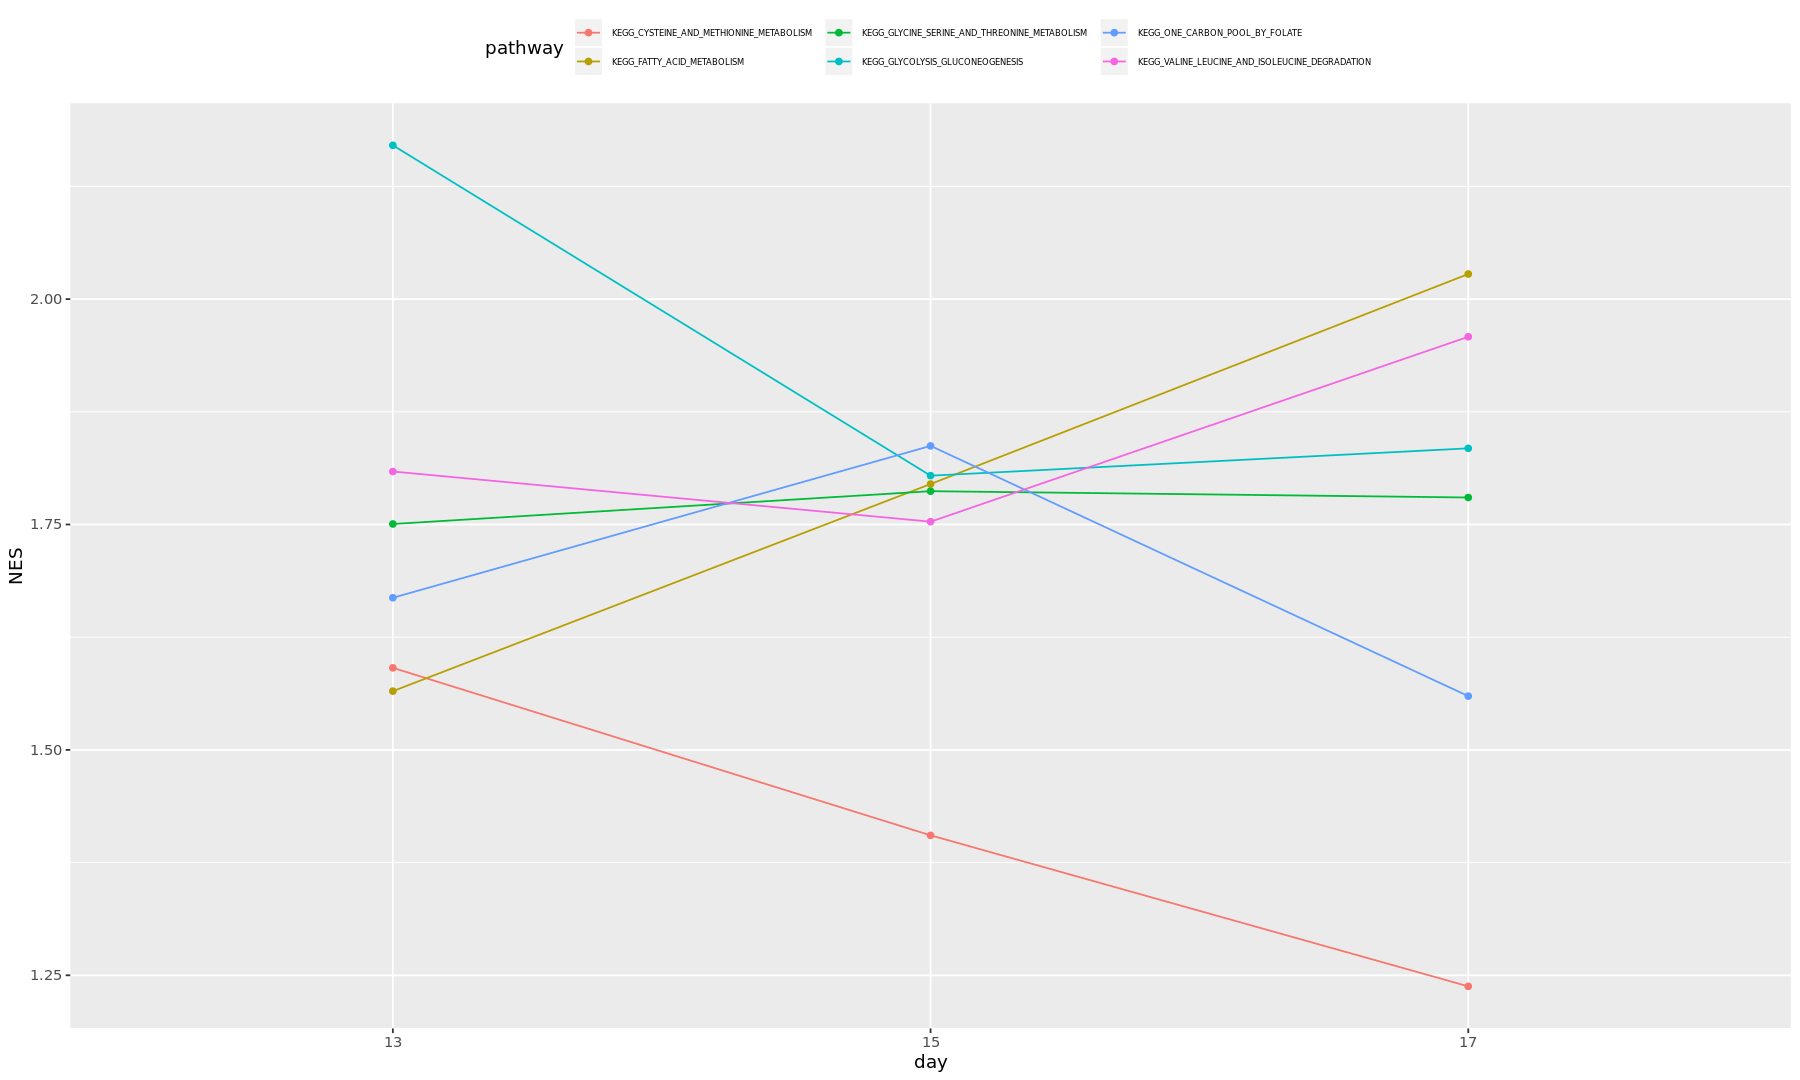

In [31]:
ggplot(data=fgsea_3_days, aes(x=day, y=NES, group=pathway)) +
  geom_line(aes(color = pathway))+
  geom_point(aes(color = pathway)) + theme(legend.position="top",
                                            legend.text=element_text(size=5))

## GSEA on all pathways for 15th day RPs vs Neurons

In [8]:
KEGG_all_pathways <- KEGG_gmt$genesets
names(KEGG_all_pathways) <- KEGG_gmt$geneset.names
KEGG_all_pathways <- lapply(KEGG_all_pathways, stringr::str_to_title)
str(KEGG_all_pathways[1:10])

List of 10
 $ KEGG_GLYCOLYSIS_GLUCONEOGENESIS              : chr [1:62] "Acss2" "Gck" "Pgk2" "Pgk1" ...
 $ KEGG_CITRATE_CYCLE_TCA_CYCLE                 : chr [1:32] "Idh3b" "Dlst" "Pck2" "Cs" ...
 $ KEGG_PENTOSE_PHOSPHATE_PATHWAY               : chr [1:27] "Rpe" "Rpia" "Pgm2" "Pgls" ...
 $ KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS: chr [1:28] "Ugt1a10" "Ugt1a8" "Rpe" "Ugt1a7" ...
 $ KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM         : chr [1:34] "Mpi" "Pmm2" "Pmm1" "Fbp2" ...
 $ KEGG_GALACTOSE_METABOLISM                    : chr [1:26] "Gck" "Galk1" "Glb1" "Gale" ...
 $ KEGG_ASCORBATE_AND_ALDARATE_METABOLISM       : chr [1:25] "Ugt1a10" "Ugt1a8" "Ugt1a7" "Ugt1a6" ...
 $ KEGG_FATTY_ACID_METABOLISM                   : chr [1:42] "Cpt1a" "Cpt1c" "Acads" "Aldh1b1" ...
 $ KEGG_STEROID_BIOSYNTHESIS                    : chr [1:17] "Soat1" "Lss" "Sqle" "Ebp" ...
 $ KEGG_PRIMARY_BILE_ACID_BIOSYNTHESIS          : chr [1:16] "Cyp46a1" "Slc27a5" "Baat" "Cyp7b1" ...


In [35]:
fgsea_Res_E15_all_pathways <- run_GSEA(ranked_genes_RPsvsNeurons_E15, KEGG_all_pathways) 
head(fgsea_Res_E15_all_pathways)

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_GLYCOLYSIS_GLUCONEOGENESIS,0.002902674,0.03393932,0.5967260,1.8052324,150,28,"Aldoc , Eno1 , Ldha , Acss1 , Tpi1 , Aldh2 , Aldoa , Pgk1 , Pfkl , Aldh7a1"
KEGG_CITRATE_CYCLE_TCA_CYCLE,0.801021775,0.92743522,0.2626062,0.7665563,41862,24,"Idh2 , Suclg2, Mdh1 , Pdha1 , Cs , Suclg1, Sdhd"
KEGG_PENTOSE_PHOSPHATE_PATHWAY,0.014302947,0.07151473,0.6468313,1.6786817,746,15,"Aldoc, Tkt , Aldoa, Dera , Pgd , Pfkl"
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,0.015385206,0.07466350,0.6093467,1.6557039,800,18,"Aldoc, Tpi1 , Aldoa, Pfkl , Phpt1, Pmm1"
KEGG_GALACTOSE_METABOLISM,0.853859538,0.93870700,0.2859049,0.6832353,44655,11,"Pfkl , Galk1, Pgm1 , Pgm2"
KEGG_FATTY_ACID_METABOLISM,0.003213958,0.03393932,0.6101991,1.7985899,167,25,"Acadl , Hadh , Eci1 , Acadm , Aldh2 , Acaa2 , Eci2 , Echs1 , Acat2 , Hadhb , Aldh7a1, Cpt1a"


### Plot the above results

In [39]:
fgsea_all_pathways_E15 <- fgsea_Res_E15_all_pathways
fgsea_all_pathways_E15$logpadj <- -log10(fgsea_all_pathways_E15$padj)
fgsea_all_pathways_E15$pathway_name <- sapply(fgsea_all_pathways_E15$pathway, function(x) gsub("_", " ", x))
fgsea_all_pathways_E15$pathway_name <- gsub("KEGG ", "", fgsea_all_pathways_E15$pathway_name)
fgsea_all_pathways_E15$pathway_name <- tolower(fgsea_all_pathways_E15$pathway_name)
simpleCap <- function(x) {
  s <- strsplit(x, " ")[[1]]
  paste(toupper(substring(s, 1,1)), substring(s, 2),
      sep="", collapse=" ")
}
fgsea_all_pathways_E15$pathway_name <- sapply(fgsea_all_pathways_E15$pathway_name, simpleCap)
fgsea_all_pathways_E15$pathway_name <- gsub("And", "and", fgsea_all_pathways_E15$pathway_name)
fgsea_all_pathways_E15[fgsea_all_pathways_E15$pathway_name == "One Carbon Pool By Folate", "pathway_name"] <- "One Carbon Metabolism"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$pathway_name == "Cysteine and Methionine Metabolism", "pathway_name"] <- "Cysteine/Methionine Metabolism"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$pathway_name == "Dna Replication", "pathway_name"] <- "DNA Replication"

pathway_mark <- c('Fatty Acid Metabolism', 'Glycolysis Gluconeogenesis', 'Cysteine/Methionine Metabolism',
                'One Carbon Metabolism', 'Glycine Serine and Threonine Metabolism',
                'Valine Leucine and Isoleucine Degradation', "Ribosome", "DNA Replication", 
                  "Cell Cycle", "Axon Guidance", "Cell Adhesion Molecules Cams", 
                  "Neuroactive Ligand Receptor Interaction", "Endocytosis", "Circadian Rhythm Mammal", 
                  "Oxidative Phosphorylation")

fgsea_all_pathways_E15$label <- sapply(as.character(fgsea_all_pathways_E15$pathway_name), function(x){
    if(x %in% pathway_mark)
       return(x)
    else 
        return("")
})
                                              
fgsea_all_pathways_E15$mark <- sapply(as.character(fgsea_all_pathways_E15$pathway_name), function(x){
    if(x %in% pathway_mark)
       return("1")
    else 
        return("0")
})
fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Cell Adhesion Molecules Cams", "label"] = "Cell Adhesion"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Glycine Serine and Threonine Metabolism", "label"] = "Glycine Serine and\nThreonine Metabolism"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Circadian Rhythm Mammal", "label"] = "Circadian Rhythm"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Neuroactive Ligand Receptor Interaction", "label"] = "Neuroactive Ligand\nReceptor Interaction"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Valine Leucine and Isoleucine Degradation", "label"] = "Valine Leucine and\nIsoleucine Degradation"

fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Cysteine/Methionine Metabolism", "label"] = "Cysteine/Methionine\nMetabolism"
fgsea_all_pathways_E15[fgsea_all_pathways_E15$label == "Fatty Acid Metabolism", "label"] = "Fatty Acid\nMetabolism"

fgsea_all_pathways_E15$enriched_in <- sapply(fgsea_all_pathways_E15$NES, function(x) if(x>0) "RPs" else "Neurons")

In [40]:
table(fgsea_all_pathways_E15$enriched_in)


Neurons     RPs 
     71      94 

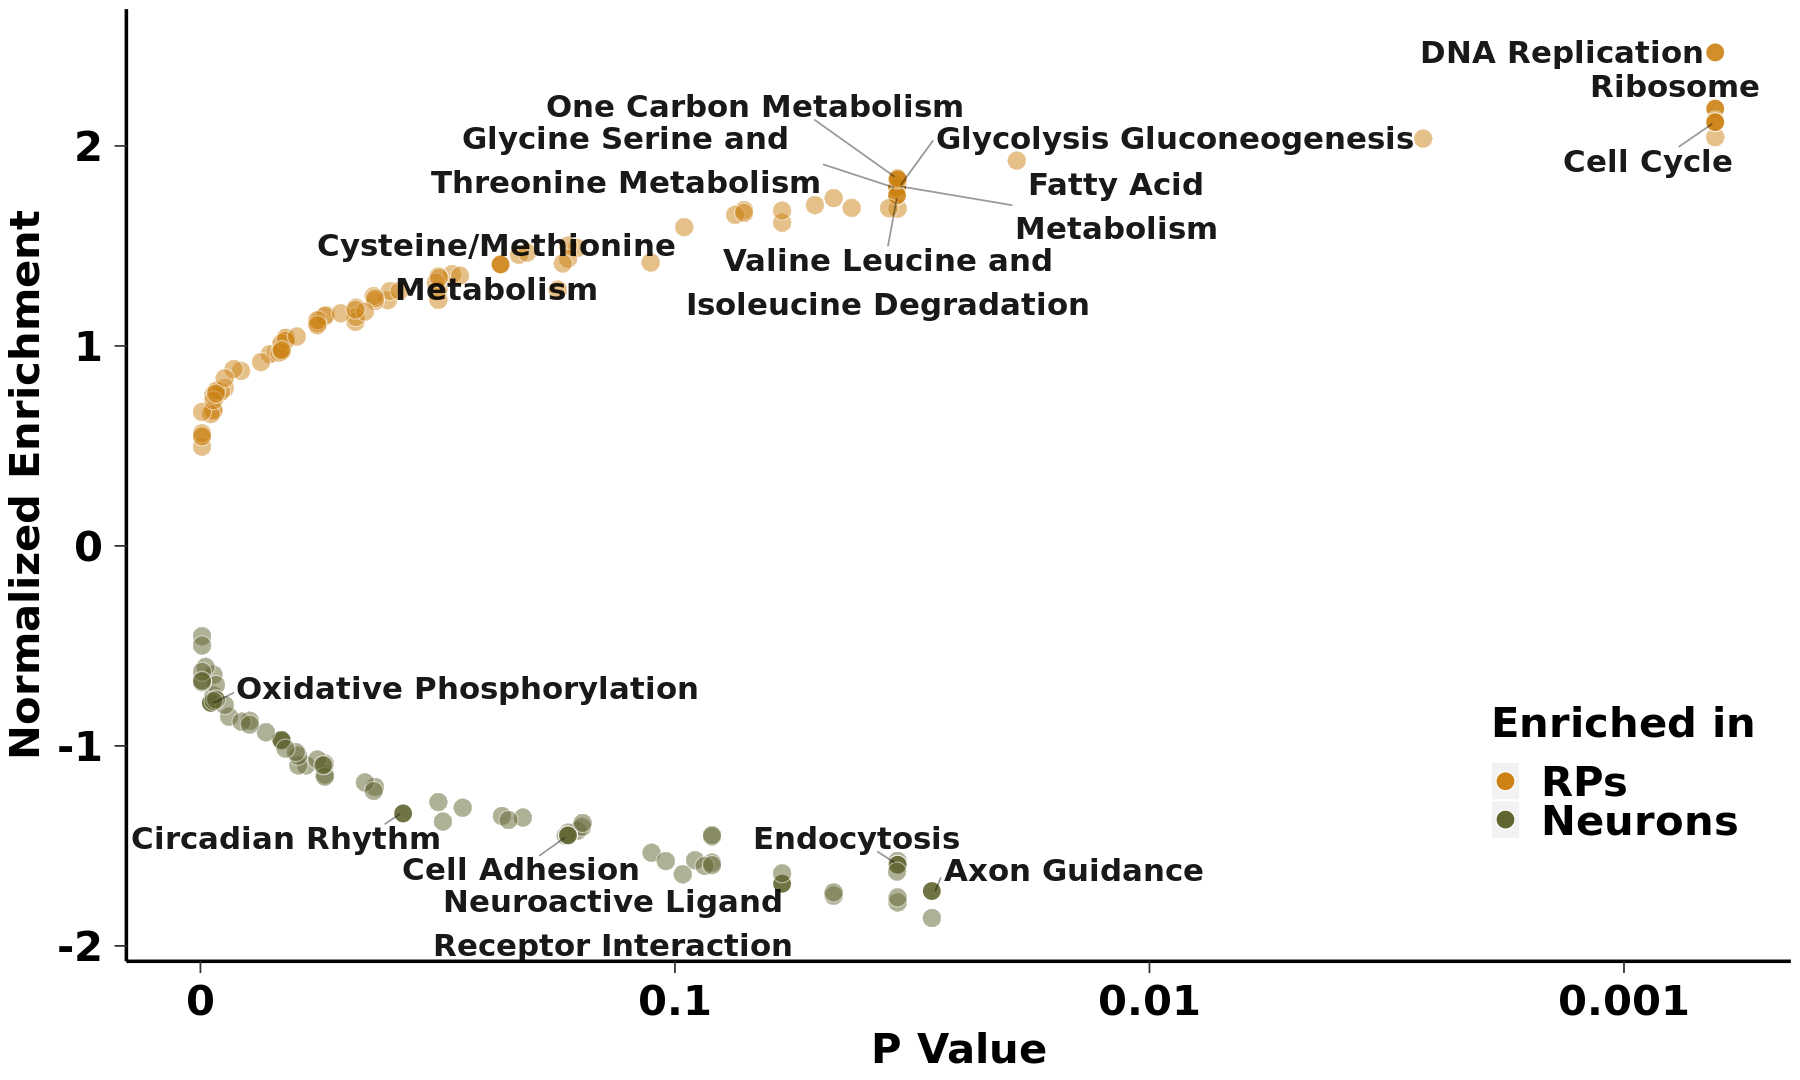

In [41]:
library(ggsci)
library(ggplot2)
library(ggrepel)

pathway_alpha <- rep(1, length(pathway_mark))
names(pathway_alpha) <- pathway_mark

p <- ggplot(fgsea_all_pathways_E15, aes(x = logpadj, y = NES, fill = enriched_in, 
                                        label = label, alpha = mark)) + 
geom_point(shape = 21, size = 5, color = "white")+
scale_alpha_manual(values = c("0"=0.5, "1"=0.9))+
scale_fill_manual(values = c("RPs"=pal_uchicago("dark")(7)[3], "Neurons"=pal_uchicago("dark")(7)[4]))+
geom_text_repel(size = 6.5, fontface = "bold", point.padding = 0.3, 
                box.padding = 0.2, segment.alpha = 0.4)+

scale_x_continuous(breaks = c(0,1,2,3), labels = c("0", "0.1", "0.01", "0.001")) + 

  labs(x = "P Value", y = "Normalized Enrichment")+
guides(fill=guide_legend(title="Enriched in", reverse = T), alpha = F)+  #scale_color_aaas() + # filling the point colors
  theme( # legend positioned at the bottom, horizantal direction,
      legend.position = c(0.9,0.2),
        axis.line = element_line(size=1, colour = "black"),	# axis line of size 1 inch in black color
        panel.grid.major = element_blank(),	# major grids included
        panel.grid.minor = element_blank(),	# no minor grids
        panel.border = element_blank(), panel.background = element_blank(), # no borders and background color
        axis.title = element_text(colour="black", size = 25, face = "bold"), # axis title 
        axis.text.x = element_text(colour="black", size = 25, margin=unit(c(0.25,0.25,0.1,0.1), "cm"), face = "bold"), # x-axis text in fontsize 10
        axis.text.y = element_text(colour="black", size = 25, margin=unit(c(0.25,0.25,0.1,0.1), "cm"), face = "bold"), # y-axis text in fontsize 10
        legend.text = element_text(colour = "black", size = 25, face = "bold"),
        legend.title = element_text(colour="black", size=25, face="bold"),
        axis.ticks.length = unit(0.25, "cm"))
p


## GSEA for 15th day s0 and S2 cells

### load E155 metabolic Seurat object from previous analysis

In [2]:
E155_Cortical_metabolic_minclusters <- readRDS("E155_Cortical_metabolic_minclusters.rds")
table(E155_Cortical_metabolic_minclusters@ident)


   0    1    2 
1487 1129  319 

### Find differentially expressed genes between S0 and S2 cells

In [3]:
E155_metabolic_minclusters_markersS0vsS2 <- FindMarkers(E155_Cortical_metabolic_minclusters, ident.1 = "2", ident.2 = "0")
head(E155_metabolic_minclusters_markersS0vsS2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dbi,4.834421e-217,3.327166,0.956,0.192,1.676577e-213
Fabp7,1.489365e-202,3.728552,0.915,0.178,5.165117e-199
Aldoc,1.361431e-199,2.834309,0.649,0.024,4.721444e-196
Gas1,3.714943e-189,2.536198,0.580,0.011,1.288342e-185
Tuba1a,1.655110e-170,-1.627806,0.987,1.000,5.739923e-167
Tubb3,1.001099e-164,-2.297652,0.458,0.993,3.471811e-161


### Run GSEA 

In [9]:
E155_metabolic_minclusters_markers_sorted <- E155_metabolic_minclusters_markersS0vsS2[order(E155_metabolic_minclusters_markersS0vsS2$avg_logFC),]
ranked_genes_vector <- E155_metabolic_minclusters_markers_sorted$avg_logFC
names(ranked_genes_vector) <- rownames(E155_metabolic_minclusters_markers_sorted)

fgseaRes_E155_S0_S2 <- fgsea(pathways = KEGG_all_pathways, 
              stats = ranked_genes_vector,
              minSize=2,
              maxSize=500,
              nperm=100000)

### Plot result

In [12]:
fgseaRes_E155_S0_S2$pathway_name <- sapply(fgseaRes_E155_S0_S2$pathway, function(x) gsub("_", " ", x))
fgseaRes_E155_S0_S2$pathway_name <- gsub("KEGG ", "", fgseaRes_E155_S0_S2$pathway_name)
fgseaRes_E155_S0_S2$pathway_name <- tolower(fgseaRes_E155_S0_S2$pathway_name)
simpleCap <- function(x) {
  s <- strsplit(x, " ")[[1]]
  paste(toupper(substring(s, 1,1)), substring(s, 2),
      sep="", collapse=" ")
}                                        
fgseaRes_E155_S0_S2$pathway_name <- sapply(fgseaRes_E155_S0_S2$pathway_name, simpleCap)
fgseaRes_E155_S0_S2$pathway_name <- gsub("And", "and", fgseaRes_E155_S0_S2$pathway_name)
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$pathway_name == "One Carbon Pool By Folate", "pathway_name"] <- "One Carbon Metabolism"
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$pathway_name == "Cysteine and Methionine Metabolism", "pathway_name"] <- "Cysteine/Methionine Metabolism"
fgseaRes_E155_S0_S2$logpadj <- -log10(fgseaRes_E155_S0_S2$padj)
                                
pathway_mark <- c('Fatty Acid Metabolism', 'Glycolysis Gluconeogenesis', 'Cysteine/Methionine Metabolism',
                'One Carbon Metabolism', 'Glycine Serine and Threonine Metabolism',
                  "Ribosome", "DNA Replication", "Cell Cycle", "Axon Guidance", "Cell Adhesion Molecules Cams", 
                  "Neuroactive Ligand Receptor Interaction", "Endocytosis", "Circadian Rhythm Mammal", 
                  "Oxidative Phosphorylation", "Spliceosome")

fgseaRes_E155_S0_S2$label <- sapply(as.character(fgseaRes_E155_S0_S2$pathway_name), function(x){
    if(x %in% pathway_mark)
       return(x)
    else 
        return("")
})
                                
fgseaRes_E155_S0_S2$mark <- sapply(as.character(fgseaRes_E155_S0_S2$pathway_name), function(x){
    if(x %in% pathway_mark)
       return("1")
    else 
        return("0")
})
                                
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$label == "Cell Adhesion Molecules Cams", "label"] = "Cell Adhesion"
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$label == "Glycine Serine and Threonine Metabolism", "label"] = "Glycine Serine and\nThreonine Metabolism"
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$label == "Circadian Rhythm Mammal", "label"] = "Circadian Rhythm"
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$label == "Neuroactive Ligand Receptor Interaction", "label"] = "Neuroactive Ligand\nReceptor Interaction"
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$label == "Cysteine/Methionine Metabolism", "label"] = "Cysteine/Methionine\nMetabolism"
fgseaRes_E155_S0_S2[fgseaRes_E155_S0_S2$label == "Fatty Acid Metabolism", "label"] = "Fatty Acid\nMetabolism"

fgseaRes_E155_S0_S2$enriched_in <- sapply(fgseaRes_E155_S0_S2$NES, function(x) if(x>0) "S0" else "S2")

table(fgseaRes_E155_S0_S2$enriched_in)                       
head(fgseaRes_E155_S0_S2)


S0 S2 
87 79 

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge,pathway_name,logpadj,label,mark,enriched_in
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<chr>,<dbl>,<chr>,<chr>,<chr>
KEGG_GLYCOLYSIS_GLUCONEOGENESIS,0.2460224,0.4980453,0.3616894,1.1997278,15199,18,"Aldoc , Eno1 , Acss1 , Tpi1 , Aldh7a1, Bpgm , Aldh2 , Pgk1",Glycolysis Gluconeogenesis,0.30273117,Glycolysis Gluconeogenesis,1,S0
KEGG_CITRATE_CYCLE_TCA_CYCLE,0.5909872,0.7975925,0.4104143,0.9026516,32654,5,"Suclg2, Idh2",Citrate Cycle Tca Cycle,0.09821892,,0,S0
KEGG_PENTOSE_PHOSPHATE_PATHWAY,0.4015415,0.6408551,0.3798398,1.0525656,23547,10,"Aldoc, Dera , Tkt , Pgd , Pfkl , Prps1",Pentose Phosphate Pathway,0.19324018,,0,S0
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,0.3445921,0.6138008,0.4137772,1.1075001,19985,9,"Aldoc, Tpi1",Fructose and Mannose Metabolism,0.21197252,,0,S0
KEGG_GALACTOSE_METABOLISM,0.3507819,0.6138008,-0.4681373,-1.0942730,15700,5,"Pfkp, Pfkm, Hk1",Galactose Metabolism,0.21197252,,0,S2
KEGG_ASCORBATE_AND_ALDARATE_METABOLISM,0.4575131,0.6842088,0.5552239,1.0267088,24287,3,"Aldh7a1, Aldh2 , Aldh9a1",Ascorbate and Aldarate Metabolism,0.16481132,,0,S0


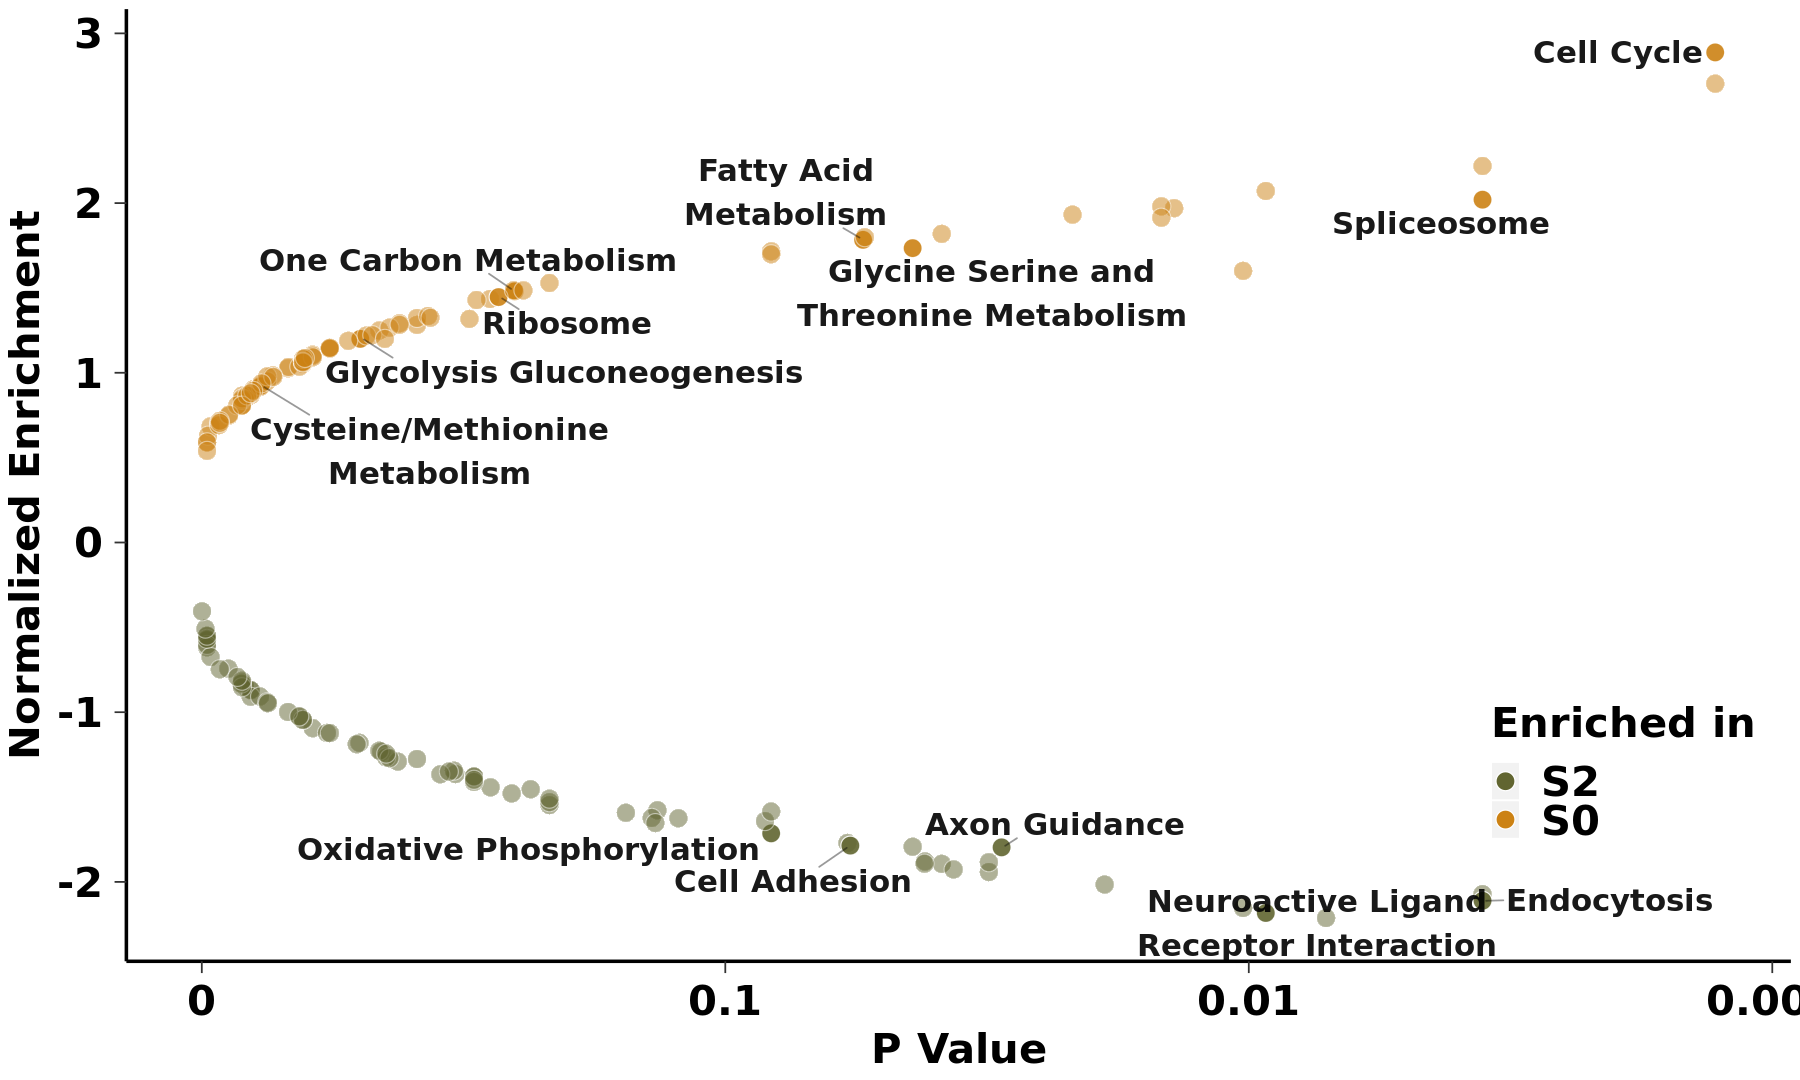

In [14]:
library(ggsci)
library(ggplot2)
library(ggrepel)

pathway_alpha <- rep(1, length(pathway_mark))
names(pathway_alpha) <- pathway_mark

p <- ggplot(fgseaRes_E155_S0_S2, aes(x = logpadj, y = NES, fill = enriched_in, 
                                        label = label, alpha = mark)) + 
geom_point(shape = 21, size = 5, color = "white")+
scale_alpha_manual(values = c("0"=0.5, "1"=0.9))+
scale_fill_manual(values = c("S0"=pal_uchicago("dark")(7)[3], "S2"=pal_uchicago("dark")(7)[4]))+
geom_text_repel(size = 6.5, fontface = "bold", point.padding = 0.3, 
                box.padding = 0.2, segment.alpha = 0.4)+

scale_x_continuous(breaks = c(0,1,2,3), labels = c("0", "0.1", "0.01", "0.001")) + 

  labs(x = "P Value", y = "Normalized Enrichment")+
guides(fill=guide_legend(title="Enriched in", reverse = T), alpha = F)+  #scale_color_aaas() + # filling the point colors
  theme( # legend positioned at the bottom, horizantal direction,
      legend.position = c(0.9,0.2),
        axis.line = element_line(size=1, colour = "black"),	# axis line of size 1 inch in black color
        panel.grid.major = element_blank(),	# major grids included
        panel.grid.minor = element_blank(),	# no minor grids
        panel.border = element_blank(), panel.background = element_blank(), # no borders and background color
        axis.title = element_text(colour="black", size = 25, face = "bold"), # axis title 
        axis.text.x = element_text(colour="black", size = 25, margin=unit(c(0.25,0.25,0.1,0.1), "cm"), face = "bold"), # x-axis text in fontsize 10
        axis.text.y = element_text(colour="black", size = 25, margin=unit(c(0.25,0.25,0.1,0.1), "cm"), face = "bold"), # y-axis text in fontsize 10
        legend.text = element_text(colour = "black", size = 25, face = "bold"),
        legend.title = element_text(colour="black", size=25, face="bold"),
        axis.ticks.length = unit(0.25, "cm"))
p
